In [ ]:
%%capture

# download dataet
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar


In [ ]:
!unrar x UCF50.rar

In [ ]:
# install the required libraries
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
import cv2
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import plot_model, to_categorical
from keras.models import Sequential
from keras.layers import *
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

### Step 0:
- chỉ xét tới 4 class: Basketball, Diving, HorseRace, Fencing
- mỗi video chỉ lấy 50 frame

In [ ]:
CLASSES = ["Basketball", "Diving", "HorseRace", "Fencing"]

SEQUENCE_LENGTH = 20

path = '/content/UCF50'

### Step 1: Visualize Data

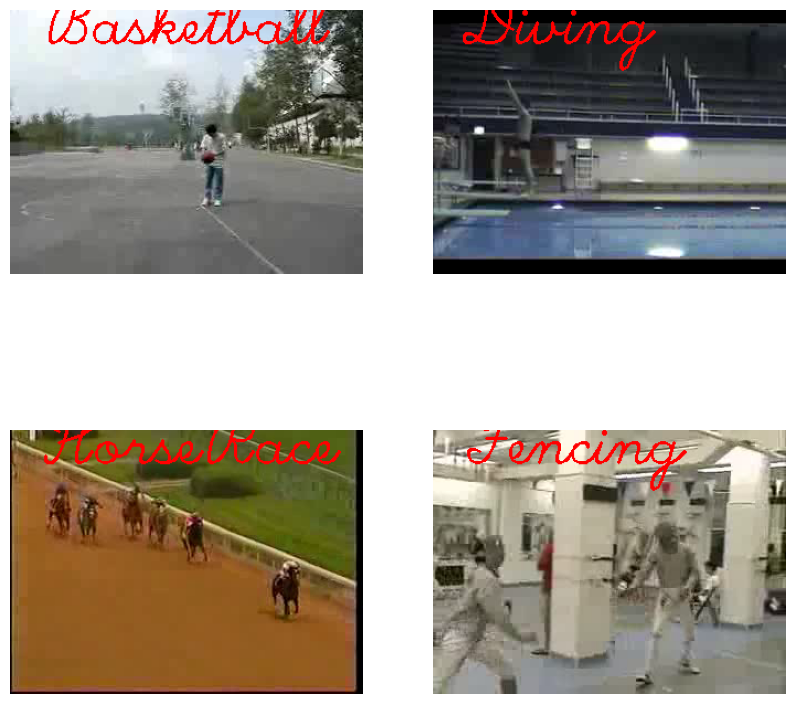

In [ ]:
# tạo 
plt.figure(figsize =(10, 10))

for counter, folder in enumerate(CLASSES):
  

  # đọc các file video trong folder
  path_videos  = os.listdir(f'{path}/{folder}')

  # chọn 1 video ngẫu nhiên để read
  path_read_video = random.choice(path_videos)

  # đọc video
  video_read = cv2.VideoCapture(f'{path}/{folder}/{path_read_video}')

  _, frame = video_read.read()

  # đóng video
  video_read.release()

  # chuyển hệ màu từ brg sang rgb
  frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

  #  ghi tên folder lên ảnh
  frame_rgb = cv2.putText(frame_rgb, folder, (30, 30), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 2, (255, 0, 0), 2)
  
  

  # show hinh
  plt.subplot(2, 2, counter+1)
  counter +=1
  plt.imshow(frame_rgb)
  
  plt.axis('off')


### Step 1: Creadte Data
- ảnh được chuyển về kích thước 64x64
- ảnh được chuẩn hóa [0:1]

# lấy Frame

In [ ]:
WIDTH, HEIGHT = 64, 64

def frame_extracting(path_file_video):

  ''' 
  đầu vào: đường dẫn tới file video
  đầu ra: mảng chứa frame đã được chuẩn hóa
  '''

  frame_list = []

  # đọc video
  video_read = cv2.VideoCapture(path_file_video)

  # lấy tổng số frame của video
  total_frame = int(video_read.get(cv2.CAP_PROP_FRAME_COUNT))

  # khoảng thời gian để lấy frame tiếp theo
  skip_frame = max(int(total_frame/SEQUENCE_LENGTH), 1)

  # lấy frame ảnh
  for frame_counter in range(SEQUENCE_LENGTH):

    # đặt tới khung mình lấy
    video_read.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frame)

    # đọc video
    success, frame = video_read.read()

    if not success:
      break

    # đặt lại kích thước frame
    frame = cv2.resize(frame, (WIDTH, HEIGHT))

    # chuẩn hóa ảnh
    frame = frame / 255

    frame_list.append(frame)
  

  video_read.release()
  return frame_list


# Read all file

In [ ]:
def Create_data():
  '''
  đọc hết file trong 4 class xét
  đầu ra: features, labels
  '''

  features = []
  labels = []

  for class_index, class_name in enumerate(CLASSES):

    print(f'Extracting of {class_name}')

    # lấy các file video trong class_name
    folder = os.listdir(os.path.join(path, class_name))

    # đọc từng file video
    for file_name in folder:

      path_file_video = os.path.join(path, class_name, file_name)

      # đọc file
      frames = frame_extracting(path_file_video)

      
      features.append(frames)
      labels.append(class_index)

  # chuyển về mảng
  features = np.asarray(features)
  labels = np.asarray(labels)

  return features, labels


In [ ]:
features, labels = Create_data()
# labels = to_categorical(labels)

Extracting of Basketball
Extracting of Diving
Extracting of HorseRace
Extracting of Fencing


In [ ]:
labels = to_categorical(labels)

In [ ]:
feature_train, feature_test, label_train, label_test = train_test_split(features, labels, test_size=0.2, random_state=100)

In [ ]:
print(features.shape)

(528, 25, 64, 64, 3)


### Step 3: Create Model
- Trong bài toán này sẽ xét 2 model
- model 1: sử dụng ConvLSTM2D
- model 2: sử dụng CNN rồi mới sử dụng LSTM


# Mode 1: ConvLSTM2D

In [ ]:
def Create_convlstm_model():

  model = Sequential()

  model.add(ConvLSTM2D(filters = 4, kernel_size=(3, 3), activation='tanh', recurrent_dropout=0.2,
                       return_sequences=True, data_format='channels_last', 
                       input_shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3)))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 8, kernel_size=(3, 3), activation='tanh', recurrent_dropout=0.2,
                       return_sequences=True, data_format='channels_last'))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  
  model.add(ConvLSTM2D(filters = 12, kernel_size=(3, 3), activation='tanh', recurrent_dropout=0.2,
                       return_sequences=True, data_format='channels_last'))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(ConvLSTM2D(filters = 16, kernel_size=(3, 3), activation='tanh', recurrent_dropout=0.2,
                       return_sequences=True, data_format='channels_last'))
  
  model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))

  model.add(Flatten())

  model.add(Dense(4, activation='softmax'))

  return model


In [ ]:
convlstm = Create_convlstm_model()

In [ ]:
convlstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_12 (ConvLSTM2D)  (None, 25, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 25, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_12 (TimeDi  (None, 25, 31, 31, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_13 (ConvLSTM2D)  (None, 25, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_13 (MaxPoolin  (None, 25, 15, 15, 8)    0         
 g3D)                                                            
                                                      

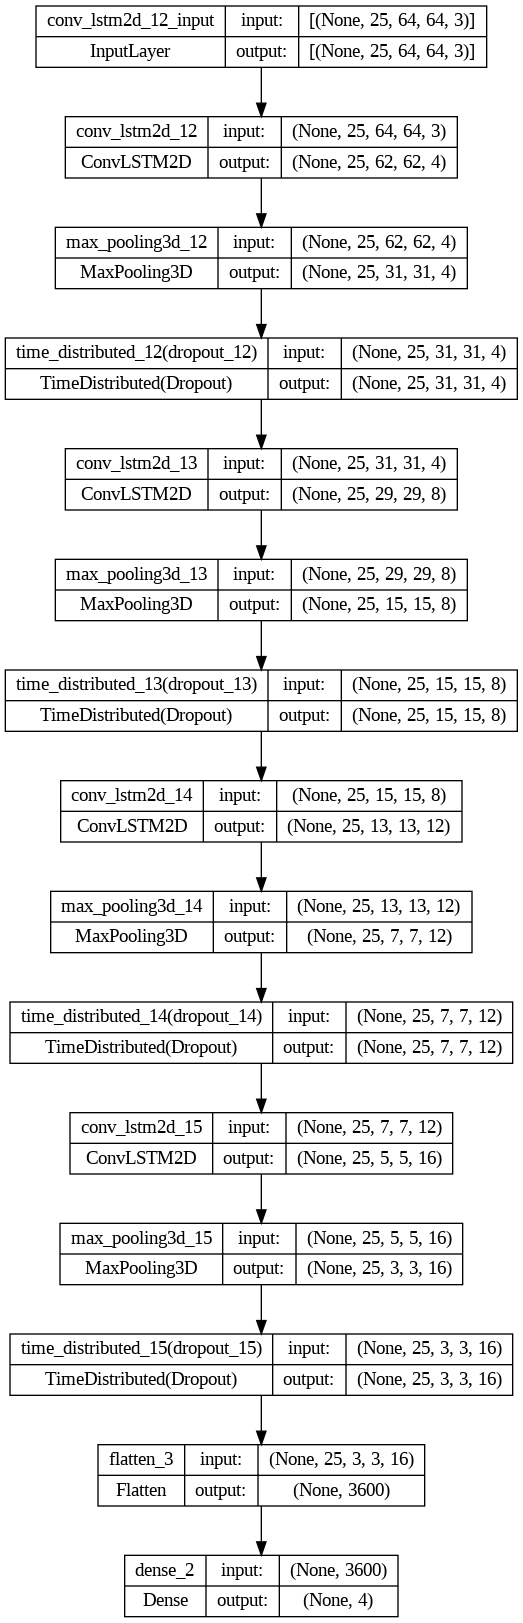

In [ ]:
plot_model(convlstm, to_file = 'convlstm_model.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10,
                                        mode = 'min', restore_best_weights=True)

# compile and cai dat ham loss, optimizer, metrics
convlstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

convlstm_training = convlstm.fit(x=feature_train, y=label_train, epochs = 50, batch_size=4,
                                                     shuffle=True, validation_split=0.2, 
                                                     callbacks=[early_stopping_callback])


Epoch 1/50
85/85 [==============================] - 83s 684ms/step - loss: 1.1884 - accuracy: 0.4570 - val_loss: 1.0461 - val_accuracy: 0.5882
Epoch 2/50
85/85 [==============================] - 56s 661ms/step - loss: 0.8193 - accuracy: 0.6766 - val_loss: 0.9006 - val_accuracy: 0.5647
Epoch 3/50
85/85 [==============================] - 57s 674ms/step - loss: 0.6807 - accuracy: 0.7418 - val_loss: 0.8838 - val_accuracy: 0.6118
Epoch 4/50
85/85 [==============================] - 55s 644ms/step - loss: 0.4589 - accuracy: 0.8427 - val_loss: 0.6573 - val_accuracy: 0.8000
Epoch 5/50
85/85 [==============================] - 55s 651ms/step - loss: 0.4205 - accuracy: 0.8694 - val_loss: 0.7810 - val_accuracy: 0.7059
Epoch 6/50
85/85 [==============================] - 57s 676ms/step - loss: 0.3832 - accuracy: 0.8635 - val_loss: 0.5391 - val_accuracy: 0.8118
Epoch 7/50
85/85 [==============================] - 55s 647ms/step - loss: 0.2278 - accuracy: 0.9199 - val_loss: 0.5189 - val_accuracy: 0.8353

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
  '''
  model_training_history: loss and accuracy
  metric_name_1: ten chi so 1
  metric_name_2: ten chi so 2
  plot_name: name of title
  '''

  # get metric
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # so luong lam truc x
  epochs = range(len(metric_value_1))

  # plot and graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # add title
  plt.title(str(plot_name))

  # add legend
  plt.legend()

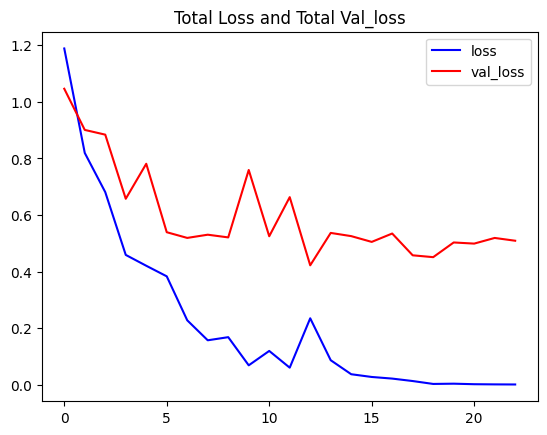

In [ ]:
# visualize the train and validation loss metrics
plot_metric(convlstm_training, 'loss', 'val_loss', 'Total Loss and Total Val_loss')

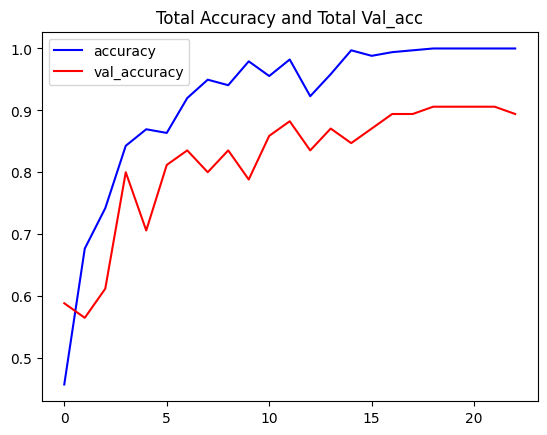

In [ ]:
# Visualize the training and validation accuracy metric
plot_metric(convlstm_training, 'accuracy', 'val_accuracy', 'Total Accuracy and Total Val_acc')

In [ ]:
evaluation_convlstm_model = convlstm.evaluate(feature_test, label_test)

4/4 [==============================] - 1s 128ms/step - loss: 0.4106 - accuracy: 0.8396


# CNN and LSTM

In [ ]:
def Cnn_Lstm():

  model = Sequential()

  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                                   input_shape= (SEQUENCE_LENGTH, WIDTH, HEIGHT, 3)))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((4, 4))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))
  

  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(32))

  model.add(Dense(4, activation='softmax'))

 

  model.summary()

  return model
  

In [ ]:
cnnlstm = Cnn_Lstm()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_138 (TimeD  (None, 25, 64, 64, 16)   448       
 istributed)                                                     
                                                                 
 time_distributed_139 (TimeD  (None, 25, 16, 16, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_140 (TimeD  (None, 25, 16, 16, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_141 (TimeD  (None, 25, 16, 16, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_142 (TimeD  (None, 25, 4, 4, 32)   

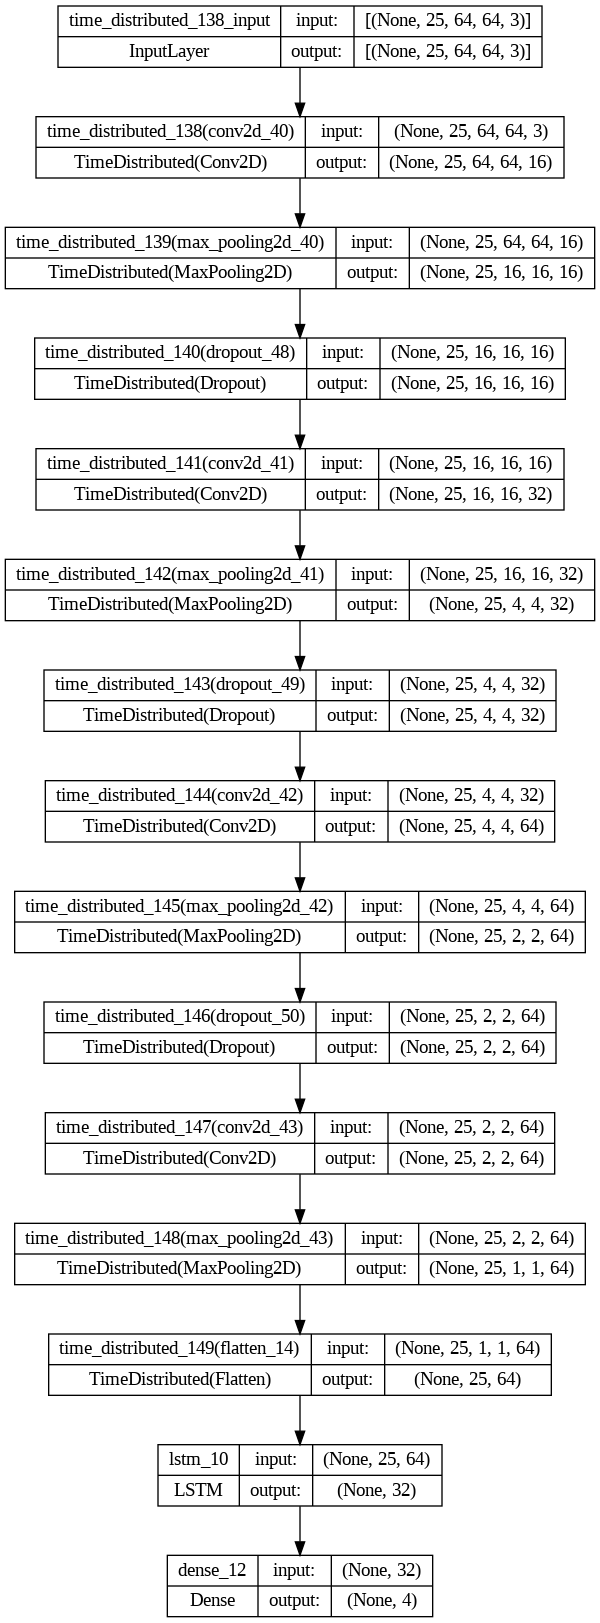

In [ ]:
plot_model(cnnlstm, to_file='cnn_lstm.png', show_shapes = True, show_layer_names= True)


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10,
                                        mode = 'min', restore_best_weights=True)

# compile and cai dat ham loss, optimizer, metrics
cnnlstm.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

cnnlstm_traing = cnnlstm.fit(x=feature_train, y=label_train, epochs = 50, batch_size=4,
                                                     shuffle=True, validation_split=0.2, 
                                                     callbacks=[early_stopping_callback])


Epoch 1/50
85/85 [==============================] - 8s 23ms/step - loss: 1.3512 - accuracy: 0.3353 - val_loss: 1.3437 - val_accuracy: 0.3294
Epoch 2/50
85/85 [==============================] - 1s 12ms/step - loss: 1.0998 - accuracy: 0.5134 - val_loss: 0.9782 - val_accuracy: 0.5529
Epoch 3/50
85/85 [==============================] - 1s 11ms/step - loss: 0.8037 - accuracy: 0.6766 - val_loss: 0.8217 - val_accuracy: 0.6706
Epoch 4/50
85/85 [==============================] - 1s 12ms/step - loss: 0.6621 - accuracy: 0.7270 - val_loss: 0.8347 - val_accuracy: 0.6471
Epoch 5/50
85/85 [==============================] - 1s 12ms/step - loss: 0.5523 - accuracy: 0.7923 - val_loss: 0.6463 - val_accuracy: 0.7412
Epoch 6/50
85/85 [==============================] - 1s 13ms/step - loss: 0.4492 - accuracy: 0.8309 - val_loss: 0.5509 - val_accuracy: 0.8000
Epoch 7/50
85/85 [==============================] - 1s 16ms/step - loss: 0.3799 - accuracy: 0.8694 - val_loss: 0.4669 - val_accuracy: 0.8235
Epoch 8/50
85

In [ ]:
evalue_cnnnlstm = cnnlstm.evaluate(feature_test, label_test)

4/4 [==============================] - 1s 58ms/step - loss: 0.2421 - accuracy: 0.9340


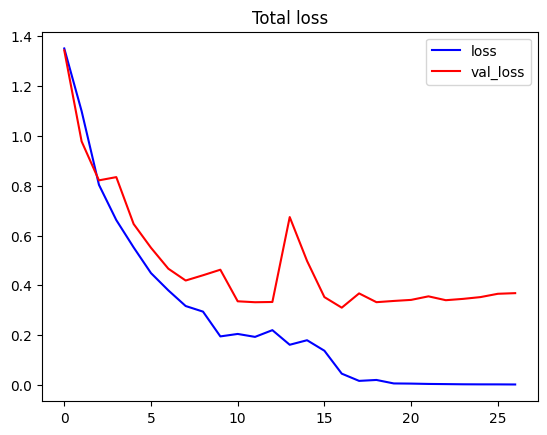

In [ ]:
plot_metric(cnnlstm_traing, 'loss', 'val_loss', 'Total loss')

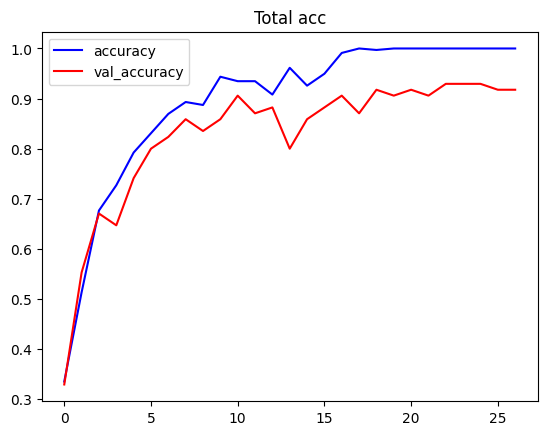

In [ ]:
plot_metric(cnnlstm_traing, 'accuracy', 'val_accuracy', 'Total acc')